# I. Distribution of fitness effect (DFE) with dadi/fitdadi
## 1. Methods
### 1.1 Summary
We used methods implemented in ∂a∂i/Fit∂a∂i to infer the DFE of new non-synonymous mutations. The method fit a demographic model to a class of sites that is assumed to be neutral and, conditional to the demographic model inferred, fit a gamma DFE model to the SFS of the focal class of sites. The method has been shown to be generally robust to linked selection when using SFS of neutral and focal classes that are interdigitated; that is, synonymous and non-synonymous sites. Therefore, we used the synonymous and non-synonymous SFS as neutral and focal classes, respectively. We fit a three-epoch demographic model to synonymous SFS per population, yielding broadly consistent results with those generated by fastsimcoal2 based on one-dimensional SFS. The method infer the mean (E(s)) and shape (β) of a gamma distribution DFE model fit on the non-synonymous SFS, accounting for demography.The mean mutational effect is estimated on a scale 2Nancs, where Nanc is a measure of the recent effective population size and s is the selection strength acting on a new mutation. The methods also consider that the fitness is reduced by 2s for homozygotes. We calculated a weighted Ne over the inferred demographic changes through time and interpolated the proportion of mutations that are assigned to four Nes ranges (0–1, 1–10, 10–100 and >100) corresponding to neutral, weakly selected, strongly selected and lethal mutations, respectively. We computed the average fixation probability of a new mutation (u) by integrating over the DFE inferred for each population separately and weighting by Nw inferred by ∂a∂i. We computed the fixation probability of a new deleterious mutation (udel) and calculated the ratio of udel over the fixation probability of a neutral mutation (uneu) as a way to quantify the relative strength of selection versus drift at removing deleterious mutations. The estimation udel/uneu has been shown to be rather robust to misspecification of the DFE model when assuming a gamma distribution. We calculated confidence intervals for estimated parameters by bootstrapping by site 100 times.
### 1.2 Demography: Three epoch model
I used the pipeline written by Portik et al. 2017 store in /Volumes/Vanuatu2/PROJET_LOAD/RESSOURCES/dadi_pipeline-master.
```sh
MD18-0148:PNG jchoin$ python3 /Volumes/Vanuatu2/PROJET_LOAD/RESSOURCES/dadi_pipeline-master/dadi_Run_Optimizations_PNG_folded.py
```

I kept the run with highest likelihood and lower AIC value. To ensure convergence I ran the pipeline 5 times. I also fitted a 3-epoch demography model using DFE-alpha and fastsimcoal using 1D folded SFS 

In ∂a∂i:
1. $\theta$ = 4L$\mu$Nanc <-> Nanc = $\theta$/(4L$\mu$) with L = 3896857 and $\mu$ = 1.25e-08 
2. Effective population size are ratios of Nanc (e.g raw N2 = N2/N1)
3. Timing of events give the duration of events (T2+T3 is when the first event started in the past)

In fastsimcoal:
1. Effective population size are given in <i>n</i> individuals
2. Timing of events are not duration

dadi:
1. Nanc is fixed and take the value of 100
2. The minimum value for T3 is 5.000
3. Timing of events give the duration of events

In [5]:
import warnings
warnings.simplefilter('ignore')

L_s = 3896857.0
L_ns = 7487474.0

vcf_file_fourfold='/Volumes/Vanuatu2/PROJET_LOAD/SFS/GLOBAL/PNG_VAN_POL_fourfold_nomissing_GERP_CHIMP_filtered_subset_noCpG.vcf'
vcf_file_zerofold='/Volumes/Vanuatu2/PROJET_LOAD/SFS/GLOBAL/PNG_VAN_POL_zerofold_nomissing_GERP_CHIMP_filtered_subset_noCpG.vcf'
corresp_file='/Volumes/Vanuatu2/PROJET_LOAD/SFS/Corresp.txt'
#for fastsimcoal Ne are haploid and T are timing no durations
fastsimcoal_params=[23550,6813,47106,3322,166]
size=18
POP='PNG'
theta_s = 2289.67
demog_params=[0.2834,45.3442,0.1272,0.0058]
fs_folded= True
fs_polarized = False
##dadi
pts = [20,30,40]
##fitdadi
pts_l = [38,48,58]
##Ouput for fitdadi
out='/Volumes/Vanuatu2/PROJET_LOAD/dadi/{}/Gamma_inference_folded.txt'.format(POP)
##Output for fitting plot
output_demo='/Volumes/Vanuatu2/PROJET_LOAD/dadi/{0}/{0}_Folded.pdf'.format(POP)

In [2]:
import sys
import os
import numpy
import dadi
from datetime import datetime
import pylab
import matplotlib.pyplot as plt

def collect_results(fs, sim_model, params_opt, roundrep, fs_folded):
    #--------------------------------------------------------------------------------------
    # gather up a bunch of results, return a list = [roundnum_repnum, log-likelihood, AIC, chi^2 test stat, theta, parameter values, sfs_sum] 
    
    # Arguments
    # fs: spectrum object name
    # sim_model: model fit with optimized parameters
    # params_opt: list of the optimized parameters
    # fs_folded: a Boolean (True, False) for whether empirical spectrum is folded or not
    #--------------------------------------------------------------------------------------

   #calculate likelihood
    ll = dadi.Inference.ll_multinom(sim_model, fs)
    ll = numpy.around(ll, 2)

    #calculate AIC 
    aic = ( -2*( float(ll))) + (2*len(params_opt))

    #calculate theta
    theta = dadi.Inference.optimal_sfs_scaling(sim_model, fs)
    theta = numpy.around(theta, 2)

    #get Chi^2
    scaled_sim_model = sim_model*theta
    if fs_folded is True:
        #calculate Chi^2 statistic for folded
        folded_sim_model = scaled_sim_model.fold()
        chi2 = numpy.sum((folded_sim_model - fs)**2/folded_sim_model)
        chi2 = numpy.around(chi2, 2)
    elif fs_folded is False:
        #calculate Chi^2 statistic for unfolded
        chi2 = numpy.sum((scaled_sim_model - fs)**2/scaled_sim_model)
        chi2 = numpy.around(chi2, 2)
    
    
    #get sum of sfs
    sfs_sum = numpy.around(fs.S(), 2)

    #store key results in temporary sublist, append to larger results list
    temp_results = [folded_sim_model, chi2]

    return temp_results

def Fit_Empirical(fs, pts, outfile, model_name, func, in_params, fs_folded=fs_folded):
    #--------------------------------------------------------------------------------------
    # Mandatory Arguments =
    #(1) fs:  spectrum object name
    #(2) pts: grid size for extrapolation, list of three values
    #(3) outfile:  prefix for output naming
    #(4) model_name: a label to slap on the output files; ex. "no_mig"
    #(5) func: access the model function from within script or from a separate python model script, ex. Models_2D.no_mig
    #(6) in_params: the previously optimized parameters to use
    #(7) fs_folded: A Boolean value indicating whether the empirical fs is folded (True) or not (False). Default is True.
    #--------------------------------------------------------------------------------------
    

        
    #create an extrapolating function 
    func_exec = dadi.Numerics.make_extrap_log_func(func)

    #simulate the model with the optimized parameters
    sim_model = func_exec(in_params, fs.sample_sizes, pts)

    rep_results = collect_results(fs, sim_model, in_params, "1", fs_folded)
    out = [sim_model, rep_results]

    return out


    
snps = vcf_file_fourfold
pop_file = corresp_file
#Create python dictionary from snps file
dd = dadi.Misc.make_data_dict_vcf(snps,pop_file)

#**************
#pop_ids is a list which should match the populations headers of your SNPs file columns
pop_ids=[POP]

#**************
#projection sizes, in ALLELES not individuals
proj = [size]

#Convert this dictionary into folded AFS object
#[polarized = False] creates folded spectrum object
fs = dadi.Spectrum.from_data_dict(dd, pop_ids=pop_ids, projections = proj, polarized = fs_polarized)


#================================================================================
# Fit the empirical data based on prior optimization results, obtain model SFS
#================================================================================
''' 
 We will use a function from the Plotting_Functions.py script:
 	Fit_Empirical(fs, pts, outfile, model_name, func, in_params, fs_folded)

Mandatory Arguments =
 	fs:  spectrum object name
 	pts: grid size for extrapolation, list of three values
 	outfile: prefix for output naming
 	model_name: a label to help name the output files; ex. "sym_mig"
 	func: access the model function from within script
 	in_params: the previously optimized parameters to use
    fs_folded: A Boolean value indicating whether the empirical fs is folded (True) or not (False).
'''

#**************
#COPY AND PASTE YOUR MODEL HERE, do not use this one!
#you can copy/paste directly from the Models_2D.py or Models_3D.py scripts

def bottleneck(params, ns, pts):
    nu_deux,nu_trois, T_deux, T_trois=params
    # Define the grid we'll use
    xx=dadi.Numerics.default_grid(pts)
    # phi for the equilibrium ancestral population
    phi=dadi.PhiManip.phi_1D(xx)
    # resize 1
    phi=dadi.Integration.one_pop(phi, xx, T_deux, nu_deux)
    # resize 2
    phi=dadi.Integration.one_pop(phi, xx, T_trois, nu_trois)
	#FS
    fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
    return fs

#create a prefix based on the population names to label the output files
#ex. Pop1_Pop2
#DO NOT EDIT THIS
prefix = "_".join(pop_ids)

#**************
#Make sure to define your extrapolation grid size.
pts=pts

#**************
#Provide best optimized parameter set for empirical data.
#These will come from previous analyses you have already completed.
emp_params = demog_params

#**************
#Fit the model using these parameters and return the model SFS.
#Here, you will want to change the "sym_mig" and sym_mig arguments to match your model, but
#everything else can stay as it is. See above for argument explanations.
model_fit = Fit_Empirical(fs, pts, prefix, "folded", bottleneck, emp_params, fs_folded=fs_folded)
expected_fs = model_fit[1]

### 1.3 Distribution of fitness effect (DFE)
#### 1.2.1 Fit∂a∂i
Fit∂a∂i estimates a population-scaled selection coefficient, scaled by twice the ancestral population size (γ = 2.Nanc.s). Nanc is computed from the value of θ$_{S}$ inferred from synonymous sites (see section 1.2.1). 
Fit∂a∂i needs θ$_{NS}$: θ$_{NS}$ = θ$_{S}$x(L$_{NS}$/L$_{S}$)

In [3]:
ratio_L = L_ns/L_s
theta_ns = theta_s*ratio_L
Nanc=theta_s/(4*1.25e-8*L_s)

In [ ]:
import numpy
import dadi
import Selection
import random

def three_epochs_s(params, ns, pts):
    nu_deux,nu_trois, T_deux, T_trois, gamma=params
    # Define the grid we'll use
    xx=dadi.Numerics.default_grid(pts)
    # phi for the equilibrium ancestral population
    phi=dadi.PhiManip.phi_1D(xx, gamma=gamma)
    # resize 1
    phi=dadi.Integration.one_pop(phi, xx, T_deux, nu_deux, gamma=gamma)
    # resize 2
    phi=dadi.Integration.one_pop(phi, xx, T_trois, nu_trois, gamma=gamma)
	#FS
    fs = dadi.Spectrum.from_phi(phi, ns, (xx,))
    return fs




theta_ns=theta_ns
ns=numpy.array([size])


pts_l = pts_l

spectra = Selection.spectra(demog_params, ns, three_epochs_s, pts_l=pts_l, 
                      int_bounds=(1e-5, 500), Npts=1000, echo=True,
                      mp=False)

dd_0fold = dadi.Misc.make_data_dict_vcf(vcf_file_zerofold, corresp_file)
fs_0fold = dadi.Spectrum.from_data_dict(dd_0fold, [POP], projections = [size], polarized = fs_polarized)



lower_bound = [1e-3, 1e-2]
upper_bound = [1, 50000.]

with open(out, 'w') as output:
    output.write("\t".join(['ID','Beta_shape','Scales_E_s','Likelihood'])+'\n')
    
    popt_list=list()
    for i in range(10):
        sel_params = [random.uniform(lower_bound[0], upper_bound[0]), random.uniform(lower_bound[1], upper_bound[1])]
        p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,upper_bound=upper_bound)

        popt = Selection.optimize_log(p0, fs_0fold ,spectra.integrate, Selection.gamma_dist,theta_ns, lower_bound=lower_bound,                
        upper_bound=upper_bound, verbose=len(sel_params), maxiter=30)
    
        output.write("\t".join(['round1_it{}'.format(i),str(popt[1][0]),str(popt[1][1]),str(popt[0])])+'\n')
        popt_list.append(popt)
    best_popt=max(popt_list)
    best_param_round_one=best_popt[1].tolist()
    
    sel_params=best_param_round_one
    for round in range(3):
        popt_list=list()
        for i in range(10):
            p0 = dadi.Misc.perturb_params(sel_params, lower_bound=lower_bound,upper_bound=upper_bound)
            popt = Selection.optimize_log(p0, fs_0fold ,spectra.integrate, Selection.gamma_dist,theta_ns, lower_bound=lower_bound,
            upper_bound=upper_bound, verbose=len(sel_params), maxiter=30)
            
            
            true_round=round+2
            output.write("\t".join(['round{0}_it{1}'.format(true_round,i),str(popt[1][0]),str(popt[1][1]),str(popt[0])])+'\n')
            popt_list.append(popt)
        best_popt=max(popt_list)
        sel_params=best_popt[1].tolist()
        
ll=list()
param=list()
with open(out, 'r') as infile:
    for i in infile:
        param.append(i.strip())
        ll.append(i.strip().split('\t')[3])
ll=ll[1:]
ll_numeric=[float(x) for x in ll]
index_max=ll_numeric.index(max(ll_numeric))
best_param=param[index_max+1].split('\t')

Beta=best_param[1]
scaled_s=best_param[2]
mean_s=float(scaled_s)/(2*Nanc)


model_sfs_dfe = spectra.integrate(numpy.array([float(x) for x in best_param[1:3]]), Selection.gamma_dist, theta_ns)

if fs_folded is True:
    #calculate Chi^2 statistic for folded
    folded_sim_model_dfe = model_sfs_dfe.fold()
    chi2 = numpy.sum((folded_sim_model_dfe - fs_0fold)**2/folded_sim_model_dfe)
    chi2 = numpy.around(chi2, 2)
elif fs_folded is False:
    #calculate Chi^2 statistic for unfolded
    chi2 = numpy.sum((model_sfs_dfe - fs_0fold)**2/model_sfs_dfe)
    chi2 = numpy.around(chi2, 2)

In [27]:
import numpy
import dadi
import Selection
import random
import inspect
#dd_0fold = dadi.Misc.make_data_dict_vcf(vcf_file_zerofold, corresp_file)
#chunks = dadi.Misc.fragment_data_dict(dd_0fold, 1000)
boot = dadi.Misc.bootstraps_from_dd_chunks(fragments=chunks,Nboot=10, pop_ids=['PNG'],projections=[18],polarized=False)
#print(inspect.getsource(dadi.Misc.bootstraps_from_dd_chunks))
#print(chunks[1:1000])

#### 1.2.2 DFE-$\alpha$
NA
### 1.4. Weighted Ne

In [33]:
import math
def compute_weighted_n_three_epoch( n1,  n2, n3,  t2_real,  t3_real):
   v1 = math.exp(-t2_real/(2.0*n2)) * math.exp(-t3_real/(2.0*n3))
   v2 = (1.0 - math.exp(-t2_real/(2.0*n2))) * math.exp(-t3_real/(2.0*n3))
   v3 = (1.0 - math.exp(-t3_real/(2.0*n3)))
   sum = (v1 + v2 + v3)
   wt_n = (n1*v1 + n2*v2 + n3*v3)/sum
   return wt_n


N1=Nanc
N2=Nanc*demog_params[0]
N3=Nanc*demog_params[1]
T2=2*Nanc*demog_params[2]
T3=2*Nanc*demog_params[3]

wNe=compute_weighted_n_three_epoch( n1=N1,  n2=N2, n3=N3,  t2_real=T2,  t3_real=T3)

### 1.5 Categories of Nes

In [34]:
%load_ext rpy2.ipython

In [35]:
%%R -i wNe -i mean_s -i Beta -o Nes_0_1 -o Nes_1_10 -o Nes_10_100 -o Nes_100
k <- as.numeric(Beta)
e_s <- 2*as.numeric(mean_s)*as.numeric(wNe)
theta <- e_s/k
Nes_0_1 <- pgamma(1, k, scale = theta)
#Nes_1_10 <- pgamma(10, k, scale = theta) - pgamma(1, k, scale = theta) - (1 - pgamma(1, k, scale = theta,lower.tail=FALSE) - (1 - ))
Nes_1_10 <- pgamma(10, k, scale = theta) - pgamma(1, k, scale = theta)
Nes_10_100 <- pgamma(100, k, scale = theta) - pgamma(10, k, scale = theta)
Nes_100 <- pgamma(100, k, scale = theta,lower.tail=FALSE)

### 1.6 Fixation probability of new deletarious alleles 

In [36]:
%%R -i wNe -i Beta -i mean_s -o udel_uneut -o efficacy_selection

kimura_fix_prob<-function(N,s)
{
  if ((s <= 0.0)&&(N*s > -1e-07))  
  {
    num = 1.0;
    denom = 2.0*N;
  }
  else if ((s >= 0.0)&&(N*s < 1e-07))
  {
    num = 1.0;
    denom = 2.0*N;
  }
  else
  {
    num = 1 - exp(-s);
    denom = 1 - exp(-2*N*s);
  }
  return (num/denom);
}

integrate_fix_prob_gamma<-function(N,beta,mean){
  x<- -rgamma(1e6,beta,beta/mean)
  x[which(x< -1)]=-1
  fix_prob<-vector(length=length(x))
  
  for (i in 1:length(x)){
    if (x[i] == 0){
      fix_prob[i] = 0.5/N;
    }
    else {
      fix_prob[i] = kimura_fix_prob(N,x[i]);
    }  
  }
  
  return(mean(fix_prob))
}

Ne <- as.numeric(wNe)
Beta <- as.numeric(Beta)
mean_s <- 2*as.numeric(mean_s)
fix <- integrate_fix_prob_gamma(N=Ne,beta=Beta,mean=mean_s)
Neutral <- kimura_fix_prob(N=Ne,s=0)

efficacy_selection <- mean_s*Ne
udel_uneut <- fix/Neutral

## 2. Results

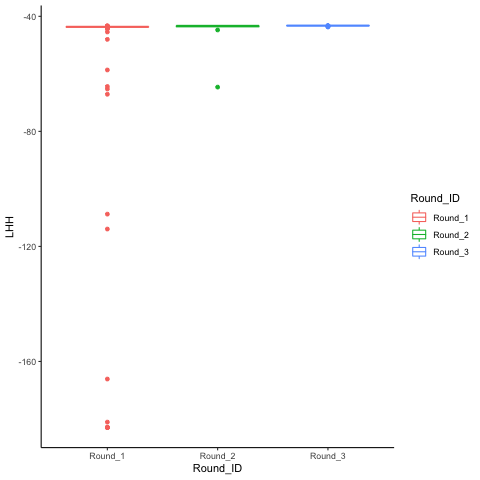

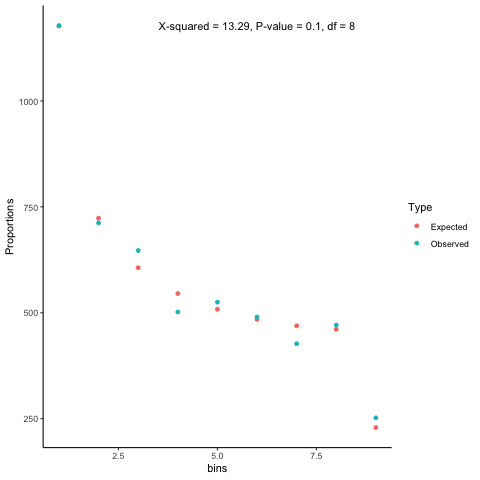

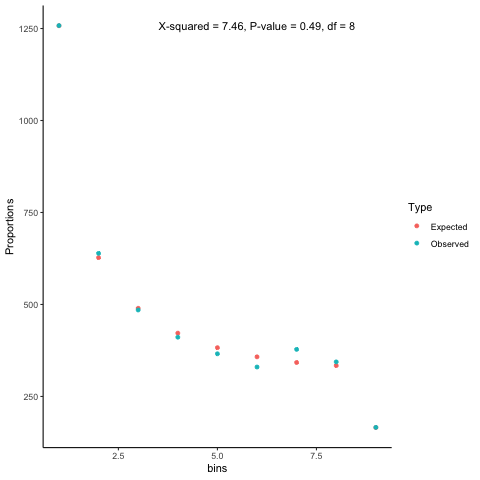

In [37]:
%%R -i fs -i expected_fs -i size -i output_demo -i folded_sim_model_dfe -i fs_0fold -i POP
library(ggplot2)
library(reshape)
library(data.table)
##Demography
###Convergence
it <- 4
round_files <-  paste('/Volumes/Vanuatu2/PROJET_LOAD/dadi/',POP,'/V5_Number_',it,'.3_epoch_',POP,'_folded.optimized.txt',sep='')
read_files <- fread(round_files,header=T,data.table=F)
split_replicate_id <- strsplit(read_files$Replicate,'_Replicate_')
Round_id <- unlist(lapply(1:length(split_replicate_id),function(x)split_replicate_id[[x]][1]))
read_files$Round_id <- Round_id
colnames(read_files) <- c('Model','Replicate','LHH','AIC','chi','theta','param','Round_ID')
###Fitting
expected_fs <- expected_fs[[1]]
expected_fs <- expected_fs[1:(size/2)+1]
fs <- fs[1:(size/2)+1]
test_khi_demo <- chisq.test(x=fs,p=expected_fs/sum(expected_fs))
test_khi_demo_value <- test_khi_demo$statistic
test_khi_demo_pval <- test_khi_demo$p.value
test_khi_demo_df <- test_khi_demo$parameter

sfs <- cbind(expected_fs, fs)
colnames(sfs) <- c('Expected','Observed')

sfs_melt <- melt(sfs)
colnames(sfs_melt) <- c('bins','Type','Proportions')




##DFE
###Fitting
folded_sim_model_dfe <- folded_sim_model_dfe[1:(size/2)+1]
fs_0fold  <- fs_0fold[1:(size/2)+1]
test_khi_dfe <- chisq.test(x=fs_0fold,p=folded_sim_model_dfe/sum(folded_sim_model_dfe))
test_khi_dfe_value <- test_khi_dfe$statistic
test_khi_dfe_pval <- test_khi_dfe$p.value
test_khi_dfe_df <- test_khi_dfe$parameter

sfs_dfe <- cbind(folded_sim_model_dfe, fs_0fold)
colnames(sfs_dfe) <- c('Expected','Observed')

sfs_dfe_melt <- melt(sfs_dfe)
colnames(sfs_dfe_melt) <- c('bins','Type','Proportions')

##Plots


annotations <- paste('X-squared = ',round(test_khi_demo_value,2),', P-value = ',round(test_khi_demo_pval,2),', df = ',test_khi_demo_df,sep="")
annotations_dfe <- paste('X-squared = ',round(test_khi_dfe_value,2),', P-value = ',round(test_khi_dfe_pval,2),', df = ',test_khi_dfe_df,sep="")

p_convergence_demo <-  ggplot(read_files, aes(x=Round_ID, y=LHH, color=Round_ID))+
     geom_boxplot() +
     theme_classic()
        
p_demo <- ggplot(sfs_melt, aes(x=bins, y=Proportions, color=Type))+
     geom_point() +
     annotate("text", x=size/3, y=max(sfs_melt$Proportions), label= annotations) + 
     theme_classic()

p_dfe <- ggplot(sfs_dfe_melt, aes(x=bins, y=Proportions, color=Type))+
     geom_point() +
     annotate("text", x=size/3, y=max(sfs_dfe_melt$Proportions), label= annotations_dfe) + 
     theme_classic()

        
pdf(output_demo)
print(p_convergence_demo)
print(p_demo)
print(p_dfe)
dev.off()

print(p_convergence_demo)
print(p_demo)
print(p_dfe)


In [38]:
from IPython.display import Markdown as md

output = md('''
<ol> 
    <li>$\\theta$<sub>NS</sub> = {0}x{1} = {2}</li>
   <li>Beta shape = {3}</li> \
   <li>scaled E[s] (2.Nanc.s) = {4}</li>
   <li>E[s] = {5}</li>
   <li> Because Fit∂a∂i assumes that the fitness of homozygotes is reduced by 2s, we need to multiply estimates for E(s) by 2: 2xE[s] = {6} </li>
   <li> Weighted Ne over 3 epochs = {7} </li>
   <li> Efficacy of selection (Nw.2E[s]) = {8} </li>
   <li> u<sub>del</sub>/u<sub>neutral</sub> = {13} </li>
   </ol>

| Software | Population | Sample size (2n) | $\\theta$ or Nanc | raw N2 | raw N3 | raw T2 | raw T3 | Nanc (2n) | N2/Nanc | N3/N2 | T2/Nanc | T3/Nanc
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: 
| ∂a∂i | {14} | {15} | {16} | {17} | {18} | {19} | {20} | {21} | {22} | {23} | {24} | {25}
| Fastsimcoal | {14} | {15} | {27} | {28} | {29} | {30} | {31} | {32} | {33} | {34} | {35} | {36}

| Software | Population | Sample size (2n) | Nw | $\\beta$ | E[s] | Nw.E[s] | Nws 0-1 | Nws 1-10 | Nws 10-100 | Nws > 100 | udel/uneu
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-:
| ∂a∂i | {14} | {15} | {7} | {26} | {6} | {8} | {9} | {10} | {11} | {12} | {13}
'''.format(theta_s,ratio_L,theta_ns,Beta,scaled_s,mean_s,2*mean_s,wNe,2*mean_s*wNe,Nes_0_1[0], Nes_1_10[0], Nes_10_100[0], Nes_100[0],udel_uneut[0],POP,size/2,theta_s,demog_params[0],demog_params[1],demog_params[2],demog_params[3],Nanc,N2/Nanc,N3/N2,T2/Nanc,T3/Nanc,Beta,fastsimcoal_params[0],fastsimcoal_params[1],fastsimcoal_params[2],fastsimcoal_params[3],fastsimcoal_params[4],fastsimcoal_params[0]/2,fastsimcoal_params[1]/fastsimcoal_params[0],fastsimcoal_params[2]/fastsimcoal_params[1],(fastsimcoal_params[3]-fastsimcoal_params[4])/(fastsimcoal_params[0]/2),(fastsimcoal_params[4])/(fastsimcoal_params[0]/2)))

output


<ol> 
    <li>$\theta$<sub>NS</sub> = 2289.67x1.9214135904910035 = 4399.403055739536</li>
   <li>Beta shape = 0.16554125030661468</li>    <li>scaled E[s] (2.Nanc.s) = 859.7104282725854</li>
   <li>E[s] = 0.036579164250601856</li>
   <li> Because Fit∂a∂i assumes that the fitness of homozygotes is reduced by 2s, we need to multiply estimates for E(s) by 2: 2xE[s] = 0.07315832850120371 </li>
   <li> Weighted Ne over 3 epochs = 8773.119647176836 </li>
   <li> Efficacy of selection (Nw.2E[s]) = 641.8267691285274 </li>
   <li> u<sub>del</sub>/u<sub>neutral</sub> = 0.24925172270493692 </li>
   </ol>

| Software | Population | Sample size (2n) | $\theta$ or Nanc | raw N2 | raw N3 | raw T2 | raw T3 | Nanc (2n) | N2/Nanc | N3/N2 | T2/Nanc | T3/Nanc
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: 
| ∂a∂i | PNG | 9.0 | 2289.67 | 0.2834 | 45.3442 | 0.1272 | 0.0058 | 11751.367833102422 | 0.2834 | 160.00070571630204 | 0.2544 | 0.0116
| Fastsimcoal | PNG | 9.0 | 23550 | 6813 | 47106 | 3322 | 166 | 11775.0 | 0.28929936305732484 | 6.914134742404228 | 0.26802547770700635 | 0.014097664543524416

| Software | Population | Sample size (2n) | Nw | $\beta$ | E[s] | Nw.E[s] | Nws 0-1 | Nws 1-10 | Nws 10-100 | Nws > 100 | udel/uneu
| :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-: | :-:
| ∂a∂i | PNG | 9.0 | 8773.119647176836 | 0.16554125030661468 | 0.07315832850120371 | 641.8267691285274 | 0.2743835645243827 | 0.1271817938541287 | 0.18440233053154087 | 0.41403231108994776 | 0.24925172270493692
